In [103]:
# Global Imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

In [2]:
def show(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    
def rgb(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def gray(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

class Plot:
    
    def __init__(self, image, title="", plotOptions=None):
        self.image = image
        self.title = title
        self.plotOptions = plotOptions

class GridPlotter:
    
    def __init__(self):
        self.images = []
        
    def add(self,image):
        if type(image) == list:
            self.images.extend(image)
            return;
        self.images.append(image)
        
    def plot(self):
        fig = plt.figure(figsize=(8, 20))
        fig.tight_layout()
        panes = np.int(np.ceil(len(self.images) / 2))
        for (idx, im) in enumerate(self.images):
            ax = fig.add_subplot(panes,2, idx + 1)
            ax.imshow(im.image, im.plotOptions)
            plt.title(im.title)
        plt.show()

In [3]:
def get_all_contours(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = []
    for contour in contours:
        rects.append(cv2.boundingRect(contour))
        
    return rects,contours

def draw_all_rects(rects, destination):
    output = destination.copy()
    idx = 1
    for rect in rects:
        [x, y, w, h] = rect
        cv2.rectangle(output, (x, y), (x + w, y + h), ((100 + idx*10) % 255, (100 + idx*10) % 255, 0), 2)
        idx+=1
    return output

def get_best_contours(image, top=10):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    sortedCnts = sorted(contours, key=cv2.contourArea, reverse=True)
    areas = [(x, cv2.contourArea(x)) for x in contours]
    mean = np.percentile([area for (c, area) in areas], top)
    filteredAreas = filter(lambda x: x[1]>mean, areas)
    filteredContours = [c for (c, a) in filteredAreas]
    
    group = []
    for contour in filteredContours:
        [x, y, w, h] = cv2.boundingRect(contour)
        group.append(cv2.boundingRect(contour))
    return group


In [4]:

class CropLayer(object):
    def __init__(self, params, blobs):
        self.xstart = 0
        self.xend = 0
        self.ystart = 0
        self.yend = 0

    # Our layer receives two inputs. We need to crop the first input blob
    # to match a shape of the second one (keeping batch size and number of channels)
    def getMemoryShapes(self, inputs):
        inputShape, targetShape = inputs[0], inputs[1]
        batchSize, numChannels = inputShape[0], inputShape[1]
        height, width = targetShape[2], targetShape[3]

        self.ystart = (inputShape[2] - targetShape[2]) // 2
        self.xstart = (inputShape[3] - targetShape[3]) // 2
        self.yend = self.ystart + height
        self.xend = self.xstart + width

        return [[batchSize, numChannels, height, width]]

    def forward(self, inputs):
        return [inputs[0][:,:,self.ystart:self.yend,self.xstart:self.xend]]

In [5]:
def compute_hist(image):
    hist = cv2.calcHist([image], [0, 1,2], None, [8, 8, 8], [0, 256, 0, 256, 0, 255])
    hist = cv2.normalize(hist, hist).flatten()
    return hist



def remove_background(im_test,all_rects, base_hist):
    """ Filter bounding boxes which are similar to background by analysing histogram """
    background_filtered_rects = []
    removed_rects = []
    for rect in all_rects:
        (bx, by, bw, bh) = rect
        hist_img = im_test[by:by+bh, bx:bx+bw]
        bhist = compute_hist(hist_img.copy())
        base2b_hist = cv2.compareHist(base_hist, bhist,  cv2.HISTCMP_CORREL)

        if base2b_hist < 0.50:
            background_filtered_rects.append(rect)
        else:
            removed_rects.append(rect)
    return background_filtered_rects


    
def filter_rects(im_width:int, im_height:int, unfiltered_rects:list):
    '''Filter bounding boxes by their aspect_ratio and absolute width/heigh > 15% of total_width '''
    filtered_rect = []
    for rect in unfiltered_rects:
        (x,y,w,h) = rect
        if w > im_width//15 and h > im_height//15 and w/h > 0.5 and h/w > 0.5:
            filtered_rect.append(rect)
    return filtered_rect

def get_cordinates(rect):
    x1, y1, w, h = rect
    x2, y2 = x1+w, y1+h
    return (x1, x2, y1, y2)

def filter_nested_rects(im_test, rects):
    '''
        Filter nested rect by comparing normalized historgram - correaltional.
        
        Nested Bounding box will be eliminate if it outer bounding box has higher histogram score.
        Parent bounding box will be eliminate if it barely(20%) matches its nested.
        
        ----
        Solves issues such as: 
        1) Parent bounding box consisting of bounding boxes enclosing different products
        2) Filter nested bounding box which does not improve representation of enclosing product
        better then parent
    '''
    sorted_rects = sorted(rects, key=lambda x: x[2] * x[3], reverse=True)
    im_width,im_height = im_test.shape[1], im_test.shape[0]
    i, j = 0, len(sorted_rects) - 1
    w_ratio, h_ratio = im_width // 10, im_height // 10
    overlapping = []

    while i < (len(sorted_rects) - 1):
        (ax1,ax2, ay1, ay2) = get_cordinates(sorted_rects[i])
        (bx1, bx2, by1, by2) = get_cordinates(sorted_rects[j])

        (ax, ay, aw, ah) = sorted_rects[i]
        (bx, by, bw, bh) = sorted_rects[j]

        a_img = im_test[ay:ay+ah, ax:ax+aw]
        b_img = im_test[by:by+bh, bx:bx+bw]

        if (bx1 >= (ax1) and bx2 <= (ax2)) and (by1 >= (ay1) and by2 <= (ay2)):
            b_x = bx - ax
            b_y = by - ay

            a_sub_b = a_img.copy()
            a_sub_b[b_y:b_y+bh, b_x:b_x+bw] = [255,255,255]

            a_sub_b_hist = cv2.compareHist(compute_hist(a_sub_b.copy()), compute_hist(b_img.copy()), cv2.HISTCMP_CORREL)
            overlapping.append((a_sub_b, b_img, a_sub_b_hist))

            if a_sub_b_hist < 0.20:
                del sorted_rects[i]
                j = len(sorted_rects) - 1
                continue
            else:
                del sorted_rects[j]
                j = j - 1 if j-1>i and j>i else len(sorted_rects) - 1
                continue
        j -= 1

        if j == i:
            i += 1
            j = len(sorted_rects) - 1
    return sorted_rects


def merge_overlapping_rects(im_test, rects):
    ''' 
        Merge bounding boxes if they are similar to each other, compared by normalized color histogram.
        constrained by w_ratio and h_ratio which are 10% of w and h.
    '''
    sorted_rects = sorted(rects, key=lambda x: x[2] * x[3], reverse=True)
    sorted_rects = rects
    i = 0
    j = len(sorted_rects) - 1
    
    while i < (len(sorted_rects) - 1):
        (ax1,ax2, ay1, ay2) = get_cordinates(sorted_rects[i])
        (bx1, bx2, by1, by2) = get_cordinates(sorted_rects[j])

        (ax, ay, aw, ah) = sorted_rects[i]
        (bx, by, bw, bh) = sorted_rects[j]

        if ((bx1 > (ax1 - 5) and bx1 < (ax2 + 5) ) or (bx2 < (ax2 - 5) and bx2 > ax1)) and ((by1 > (ay1 - 5) and by1 < (ay2 + 5) ) or (by2 < (ay2 + 5) and by2 > (ay1 - 5))):
                a = im_test[ay:ay+ah, ax:ax+aw]
                b = im_test[by:by+bh, bx:bx+bw]
                ahist = compute_hist(a.copy())
                bhist = compute_hist(b.copy())
                
                a2b_hist = cv2.compareHist(ahist, bhist, cv2.HISTCMP_CORREL)
                
#                 show(a);show(b)
#                 print(a2b_hist)
                
                if(a2b_hist > 0.6):
                    n_x1,n_x2, n_y1, n_y2 = min(bx1, ax1), max(bx2, ax2), min(by1, ay1), max(by2, ay2)
                    sorted_rects[i] = (n_x1, n_y1, abs(n_x2-n_x1), abs(n_y2-n_y1))
                    del sorted_rects[j]
        if (j == i) or (j - 1 <= i):
            i += 1
            j = len(sorted_rects) - 1
        else:   
            j -= 1


    return sorted_rects



In [6]:
class ImageSegementation:
    
    def __init__(self, background_img_path):
        bg_img = cv2.imread(background_img_path)
        self.bg_hist = compute_hist(bg_img)
        
    def init_hed(self):
        self.HED_DNN = cv2.dnn.readNet("./opencv-models/deploy.prototxt", "./opencv-models/hed_pretrained_bsds.caffemodel")    
        cv2.dnn_registerLayer('Crop', CropLayer)
    
    def segment(self, image_to_segment):
        print("tracing image")
        traced_edges = self._trace_edges(image_to_segment)
        print('image traced')
        im_canny = cv2.Canny(traced_edges, 100,255)
        all_rects, all_contours = get_all_contours(im_canny)
        
        im = image_to_segment.copy()
        im_width = image_to_segment.shape[1]
        im_height = image_to_segment.shape[0]
        
        print('filtering rects')
        filtered_rects = filter_rects(im_width, im_height, all_rects)
        filtered_rects = remove_background(im, filtered_rects, self.bg_hist)
        filtered_rects = filter_nested_rects(im, filtered_rects)
        filtered_rects = merge_overlapping_rects(im, filtered_rects)
        
        return filtered_rects

    
    def _trace_edges(self, im):
        inp = cv2.dnn.blobFromImage(im, scalefactor=1.0,swapRB=False,crop=False)
        self.HED_DNN.setInput(inp)
        output = self.HED_DNN.forward()
        output = output[0, 0] # since, shape will be 4 dimensional eg. (1, 1, 1560, 2080)
        output = 255 * output # the intensity are were normalized
        output = output.astype(np.uint8)
        return output


In [7]:
image_segementation = ImageSegementation('samples/background.jpeg')
image_segementation.init_hed()

tracing image
image traced
filtering rects


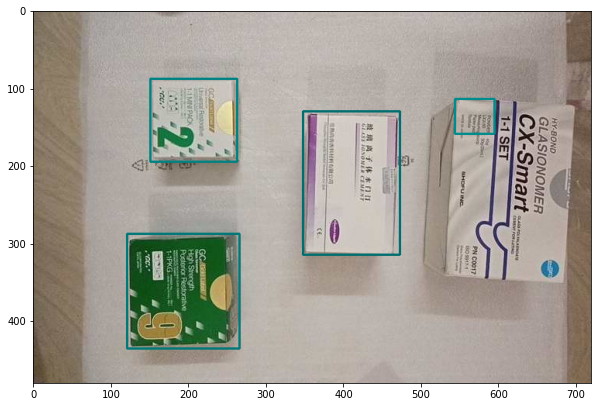

In [100]:
sample = cv2.imread('test_images/IMG_20210628_181744.jpg')
# sample = cv2.imread(f'test_images/IMG_20210628_181744.jpg')
if(sample.shape[0] > 1000):
    sample = cv2.resize(sample, (sample.shape[1]//5,sample.shape[0]//5))
rects = image_segementation.segment(sample)
show(draw_all_rects(rects, sample))

In [23]:
np.random.choice([1,2,3,4], size=3, replace=False)

array([4, 2, 1])

In [24]:
import os
directory = 'data-source-2'
samples = [f'{directory}/{x}' for x in np.random.choice(os.listdir(directory), size=8, replace=False) if x.split('.')[1] == 'jpg']

In [53]:
# for path in samples:
#     sample = cv2.imread(path)
#     if(sample.shape[0] > 1000):
#         sample = cv2.resize(sample, (sample.shape[1]//5,sample.shape[0]//5))
#     rects = image_segementation.segment(sample)
#     show(draw_all_rects(rects, sample))

### Training Model

The neural network is truncated replica of GoogLeNet. The parallel approach worked very well with small dataset, particularly the dataset used for this project. Providing validation accuracy of 92%.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import datasets, layers, models
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.nn import conv2d
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

In [ ]:
df = pd.read_csv('image-dataset/index.csv', usecols=['name', 'label'])
print(df.shape)
files = df.name.values
image_string_labels = df.label.values

labelEncoder = LabelEncoder()
labels = labelEncoder.fit_transform(image_string_labels)
num_labels = len(labelEncoder.classes_)

X, y = files, labels
x_train, x_test,y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.05)
# x_train, y_train = X, y
df.loc[:,'category'] = labels

In [ ]:
img_height, img_width = 224,224
batch_size = 36

train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.0],
    validation_split=0.1)


train_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='name',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='raw')


validation_generator = train_datagen.flow_from_dataframe(
    df,
    x_col='name',
    y_col='category',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='raw')

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))

def name_to_image(file_name, label):
    image = tf.io.read_file(f'{file_name.numpy().decode("utf-8")}') 
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def set_shapes(f, l):
    f.set_shape((224,224,3))
    l.set_shape(())
    return f, l

test_dataset = test_dataset.map(lambda fn,lb: tf.py_function(name_to_image, [fn, lb], [tf.float32, tf.int64])).map(set_shapes).batch(10)

In [ ]:
def plot_model_accuracy(history_fine):    
    
    acc = history_fine.history['accuracy']
    val_acc = history_fine.history['val_accuracy']

    loss = history_fine.history['loss']
    val_loss = history_fine.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='lower right')

    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [ ]:
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 

    path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)


    path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)


    path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
    path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)


    path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
    path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)

    output_layer = concatenate([path1, path2, path3, path4], axis = -1)
    return output_layer

def get_inception_net():
    input_layer = Input(shape = (224, 224, 3))

    X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)

    X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)

    # 1st Inception block
    X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)
    X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)

    # 2nd Inception block
    X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)
    X = AveragePooling2D(pool_size = (5,5), strides = 3)(X)

    X = Flatten()(X)
    X = Dense(1024, activation = 'relu')(X)
    X = Dropout(0.5)(X)

    # output layer 
    X = Dense(num_labels, activation = 'softmax')(X)

    googlenet_model = Model(input_layer, X, name = 'GoogLeNet')

    googlenet_model.compile(optimizer='adam',
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=['accuracy'])
    
    return googlenet_model

GLN_CHECKPOINTS = 'gln_cnn__ckpt'
if not os.path.exists(GLN_CHECKPOINTS):
    os.makedirs(GLN_CHECKPOINTS)

model = make_or_restore_model(get_inception_net, GLN_CHECKPOINTS)

callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=GLN_CHECKPOINTS + "/ckpt-loss={loss:.2f}", save_freq=32*5
    )
]

history = model.fit(train_generator, epochs=20, 
                    validation_data=validation_generator, callbacks=callbacks, batch_size=32)

plot_model_accuracy(history)

In [ ]:
model.save('incep_cnn_v1.h5')

### Classification

In [78]:
# Load trained model weights

import tensorflow as tf
# model = tf.keras.models.load_model('cnn-v2.h5')
# model_2 = tf.keras.models.load_model('models/modelv2.h5')
model_3 = tf.keras.models.load_model('all_saved_models_2/incep_cnn_v1.h5')
# model_4 = tf.keras.models.load_model('all_saved_models_2/simple_cnn_v1.h5')
# model_5 = tf.keras.models.load_model('all_saved_models_2/vgg_cnn_v1.h5')

In [97]:
model_3.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 109, 109, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 54, 54, 64)   0           conv2d_13[0][0]                  
__________________________________________________________________________________________________
conv2d_15 (Conv2D)              (None, 54, 54, 96)   6240        max_pooling2d_4[0][0]            
__________________________________________________________________________________________

In [94]:
# sample = cv2.imread(f'data-source-2/IMG_20210618_090156.jpg')
path_1 = 'samples/products_1.jpeg'
path_2 = 'data-source-2/IMG_20210618_085808.jpg'
test_images = ['test_images/IMG_20210628_181635.jpg', 'test_images/IMG_20210628_181606.jpg',
              'test_images/IMG_20210628_181712.jpg', 'test_images/IMG_20210628_181646.jpg',
              'test_images/IMG_20210628_181744.jpg']
sample = cv2.imread(test_images[4])
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
if(sample.shape[0] > 1000):
    sample = cv2.resize(sample, (sample.shape[1]//2,sample.shape[0]//2))

rects = image_segementation.segment(sample)

tracing image
image traced
filtering rects


In [13]:
import pickle

with open('label_encoder.p', 'rb') as file:
    labelEncoder = pickle.load(file)

In [101]:
labelEncoder.classes_

array(['changshu_glasionomer', 'dpi_impression_paste', 'gc_type_2_mini',
       'gc_type_9', 'gp_point', 'hybond_cx_smart', 'kfile', 'lute_glass',
       'orafil_g_plus', 'pearsals_suture_thread', 'prime_chroma_alginate',
       'prime_templute', 'progel_anesthetic', 'romsons_needle'],
      dtype=object)

['hybond_cx_smart']


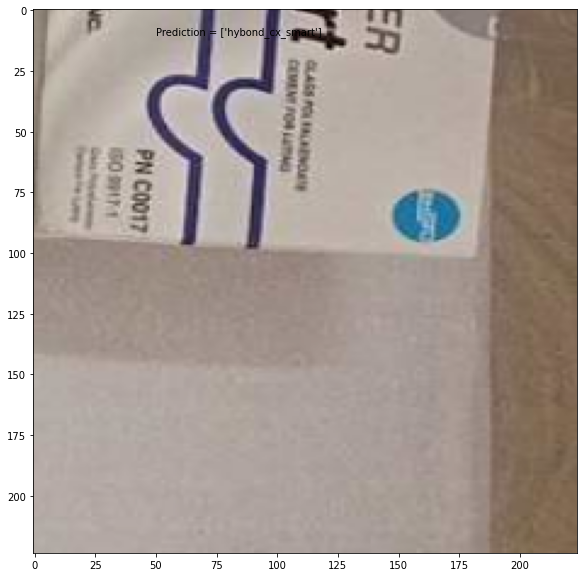

['romsons_needle']


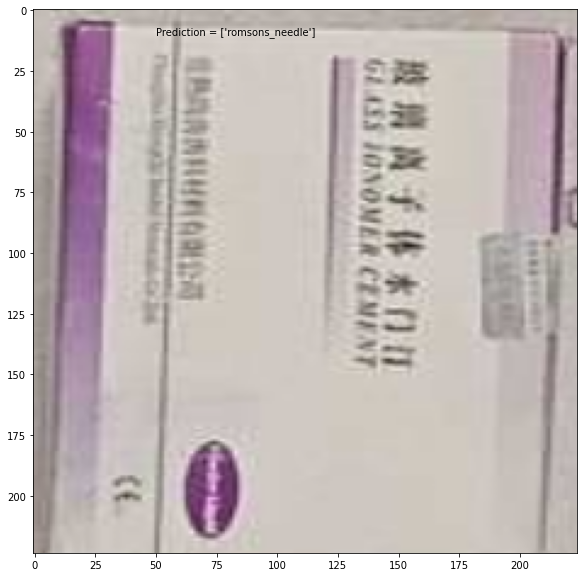

['kfile']


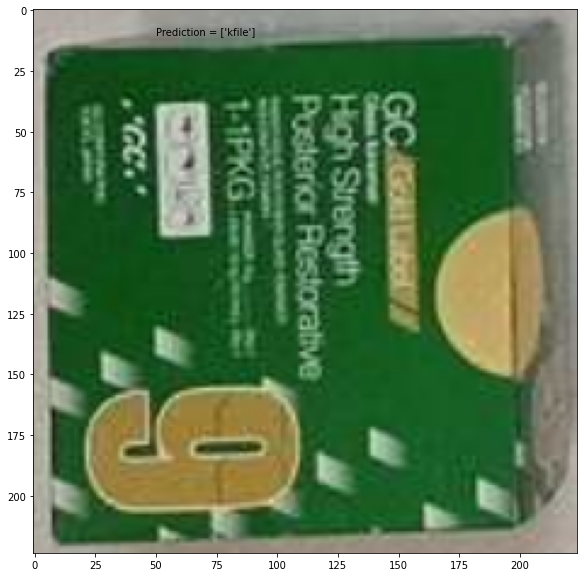

['gc_type_2_mini']


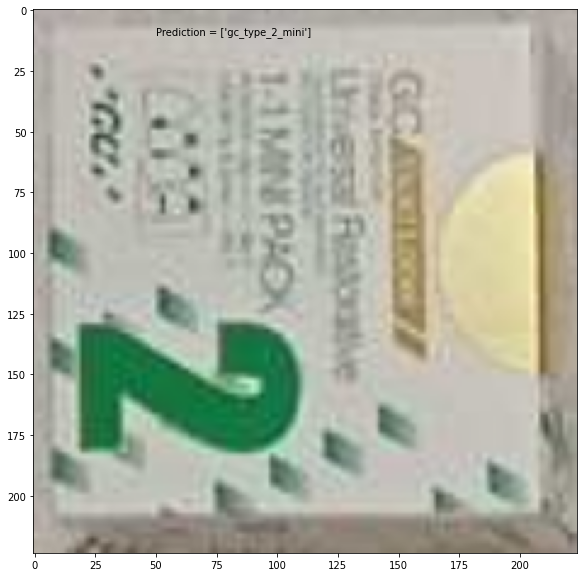

In [63]:
for (x1,y1, w, h) in rects:
    im_test = sample[y1:y1+h, x1:x1+w]
    im_test = cv2.resize(im_test, (224,224))
    plt.imshow(im_test)
    model_input = np.reshape(im_test, (-1,224,224,3))
    res = model_3.predict(model_input)
    res = np.squeeze(res)
    prediction = res.argmax()
    prediction = labelEncoder.inverse_transform([prediction])
    plt.text(50, 10, f"Prediction = {prediction}")
    print(prediction)
    plt.show()

### Visualizing Conv2D layers

In [105]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from numpy import expand_dims

img = load_img('samples/test_5.jpeg')
img_arr = img_to_array(img)
image = tf.cast(img_arr, tf.float32) / 255.0
image = tf.image.resize(image, (224,224))
image = expand_dims(image, axis=0)

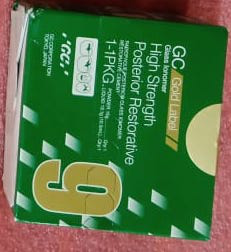

In [106]:
img

In [110]:
all_conv_layers = []
for layer in model_3.layers:
    if 'conv' in layer.name:
        all_conv_layers.append(layer)

#### First Layer

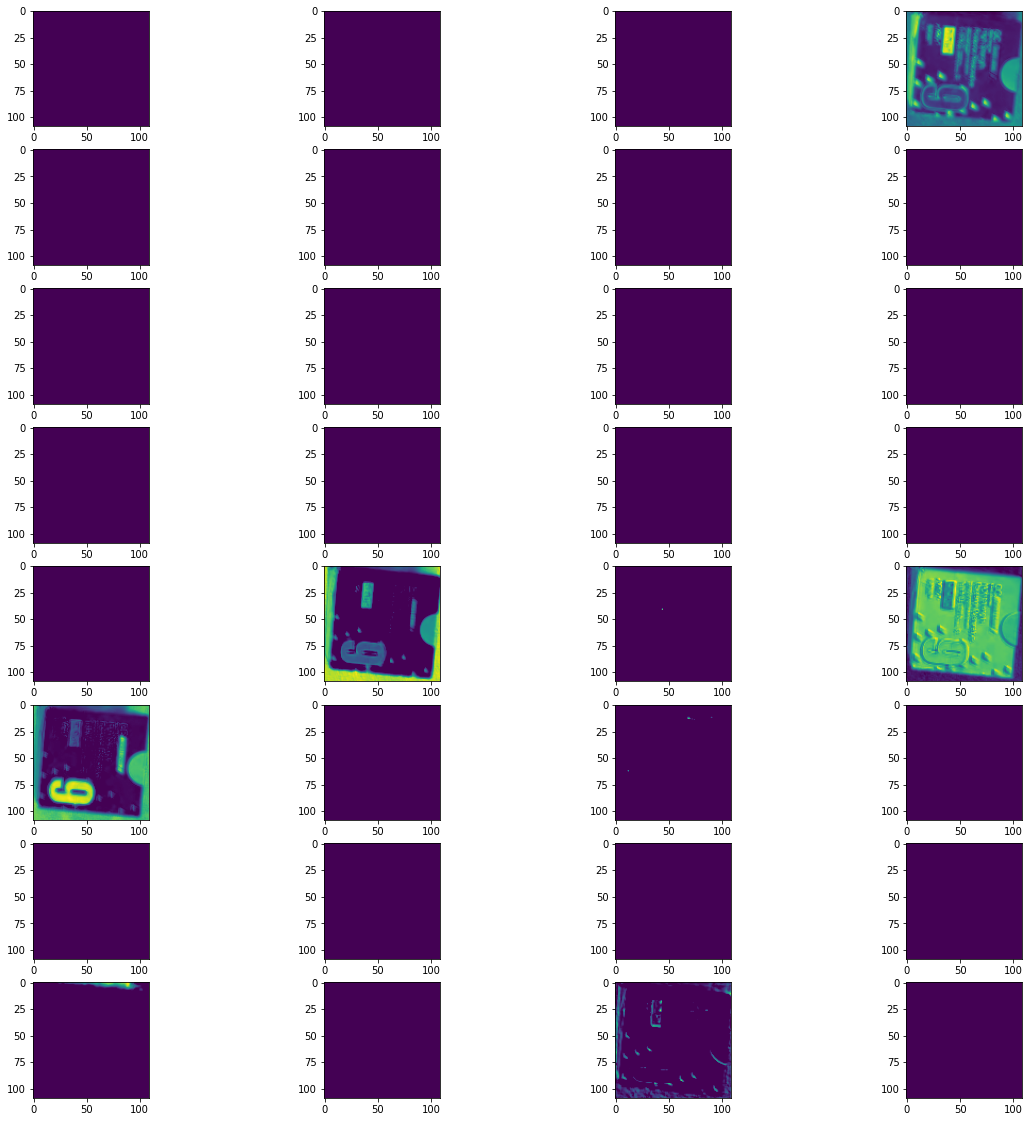

In [117]:
conv_model_1 = Model(inputs=model_3.inputs, outputs=all_conv_layers[0].output)

plt.figure(figsize=(20,20))
for idx in range(32):
    pred = conv_model_1.predict(image)
    plt.subplot(8,4, idx + 1)
    plt.imshow(pred[0,:,:,idx])
plt.show()

#### Second Layer

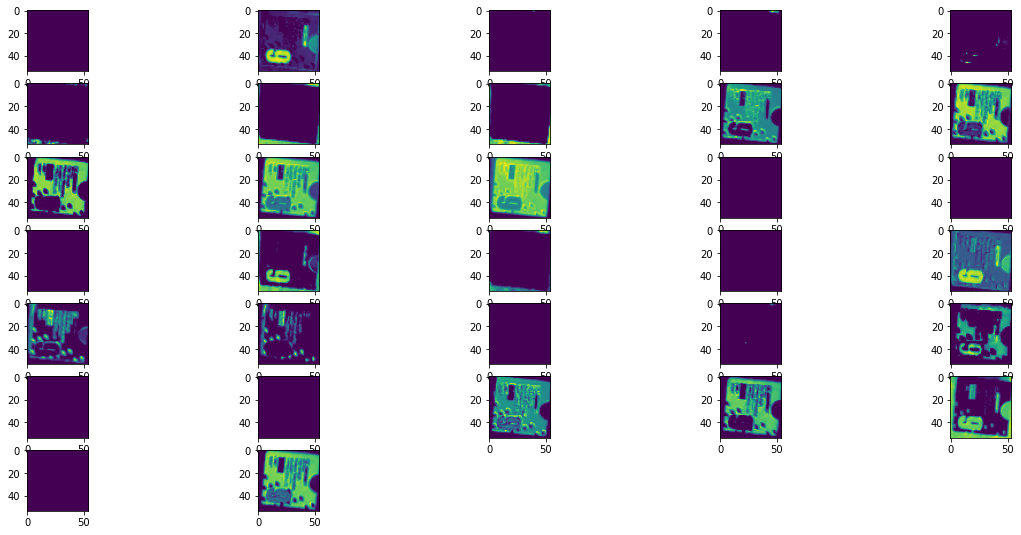

In [119]:
conv_model_2 = Model(inputs=model_3.inputs, outputs=all_conv_layers[1].output)

plt.figure(figsize=(20,20))
for idx in range(32):
    pred = conv_model_2.predict(image)
    plt.subplot(15,5, idx + 1)
    plt.imshow(pred[0,:,:,idx])
plt.show()

#### Third Layer

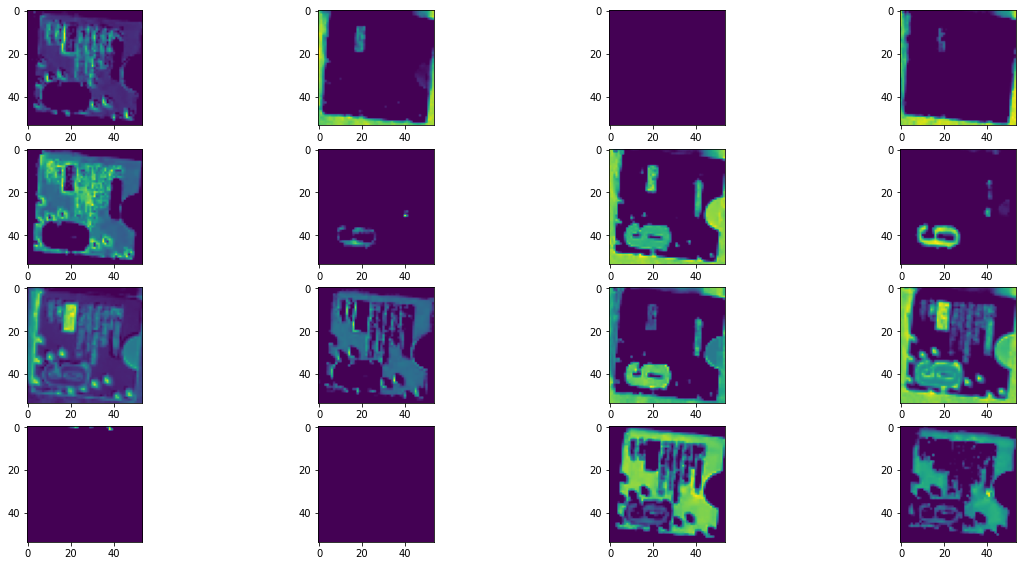

In [122]:
conv_model_3 = Model(inputs=model_3.inputs, outputs=all_conv_layers[2].output)

plt.figure(figsize=(20,20))
for idx in range(16):
    pred = conv_model_3.predict(image)
    plt.subplot(8,4, idx + 1)
    plt.imshow(pred[0,:,:,idx])
plt.show()

#### Last Layer

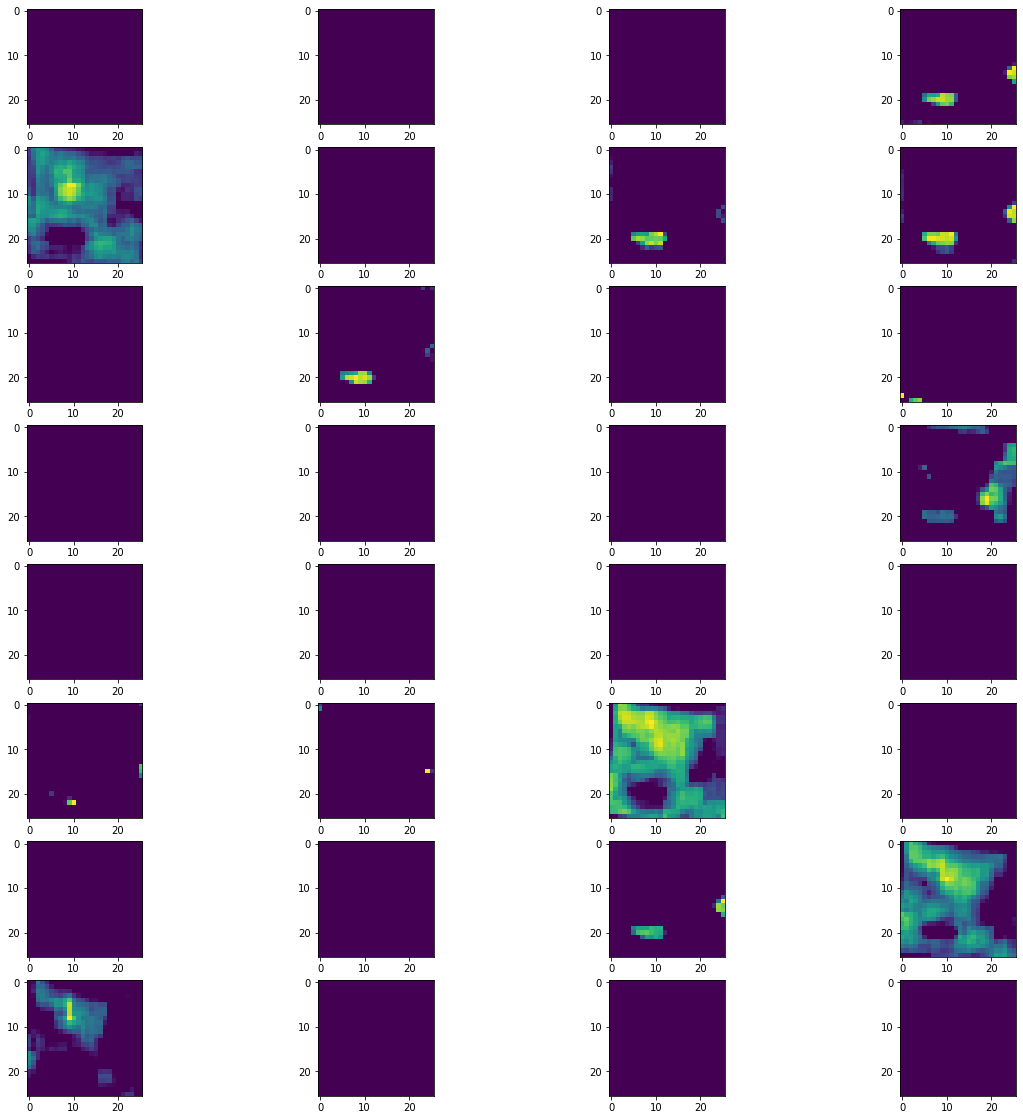

In [125]:
conv_model_3 = Model(inputs=model_3.inputs, outputs=all_conv_layers[-1].output)

plt.figure(figsize=(20,20))
for idx in range(32):
    pred = conv_model_3.predict(image)
    plt.subplot(8,4, idx + 1)
    plt.imshow(pred[0,:,:,idx])
plt.show()

### Data Augmentation

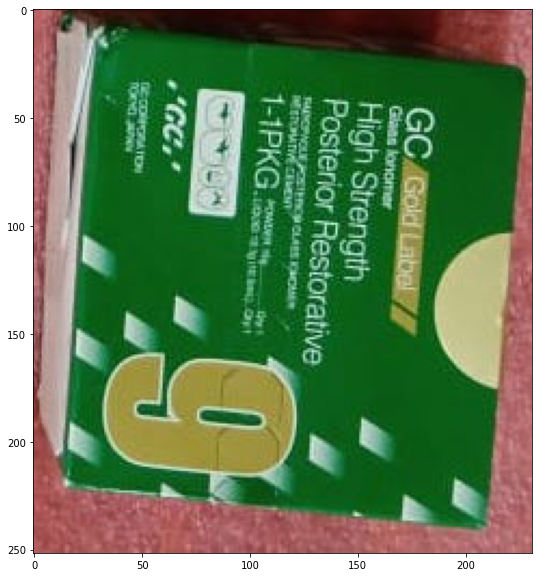

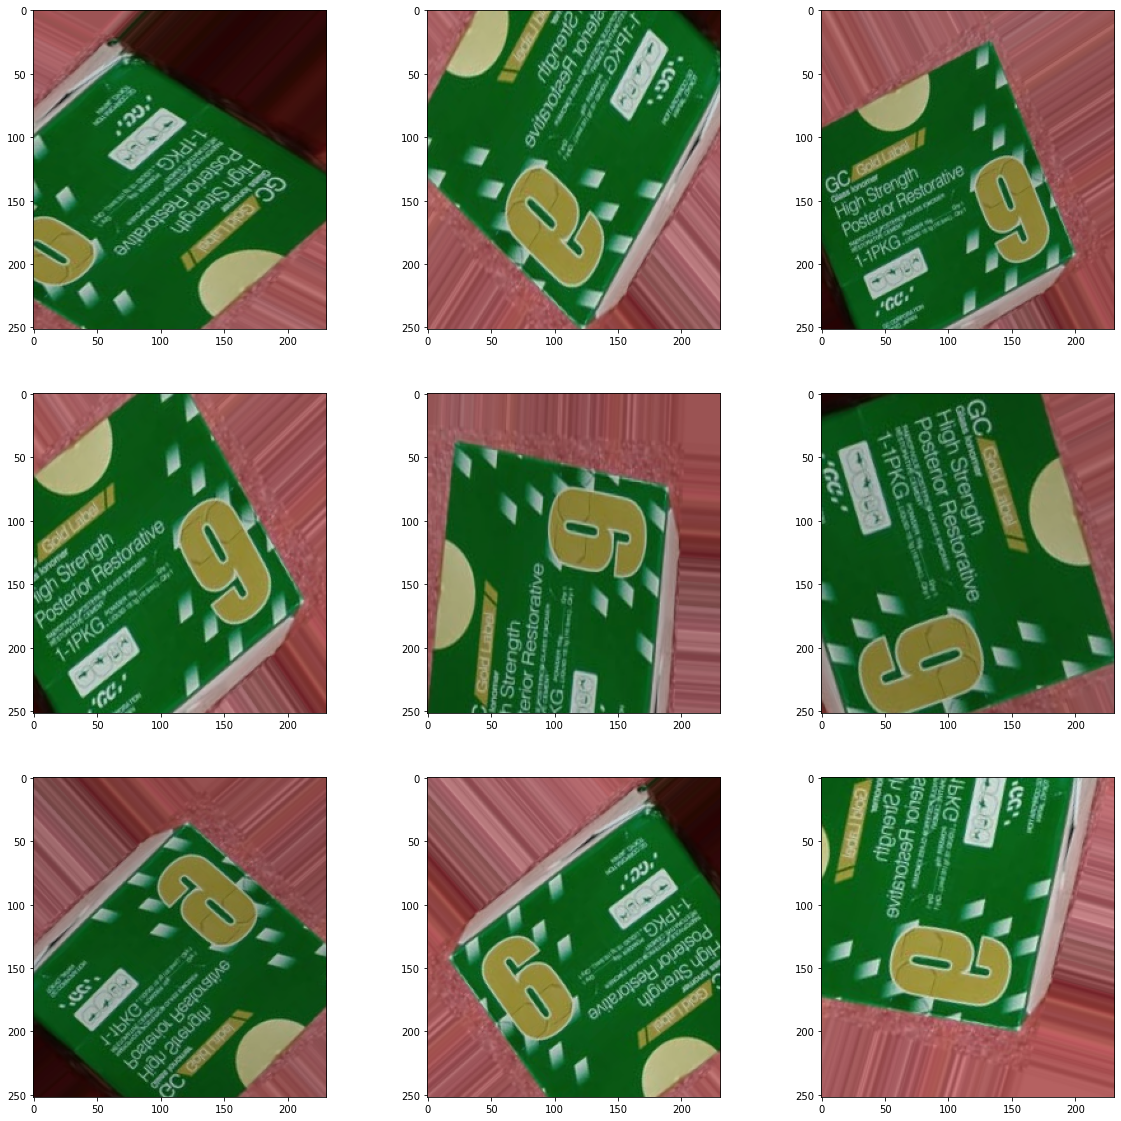

In [126]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

img = load_img('samples/test_5.jpeg')
plt.imshow(img)
plt.show()
data = img_to_array(img)
samples = expand_dims(data, 0)
# datagen = ImageDataGenerator(width_shift_range=[-0.2,0.2])
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8,1.0],
    validation_split=0.1
)

it = datagen.flow(samples, batch_size=1)

plt.figure(figsize=(20,20))
for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0].astype('uint8')
    plt.imshow(image)

plt.show()